In [1]:
import tensorflow as tf
from tensorflow.python.ops.rnn import _transpose_batch_time

from datetime import datetime
import numpy as np
import pandas as pd
import glob, os, sys, math, warnings, copy, time, glob
import matplotlib.pyplot as plt
os.environ["TF_CPP_MIN_LOG_LEVEL"]="3"

# customized ftns 
from preprocessing import *
from features import *
from utilities import *
from model import *
from train import train_all_single_policies
# ---------------------------------------------------------
%matplotlib inline
%load_ext autoreload
%autoreload 2
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')
# ---------------------------------------------------------
# directories
main_dir = '../'
game_dir = main_dir+'data/'
Data = LoadData(main_dir, game_dir)
models_path = './models/' 

/home/sam/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/sam/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### Pre-process 
filter events, subsample frames, add velocity, reorder moments, re-arrange team order
shot clock, filter out event with short moments

In [2]:
all_games_id = [i.split('/')[-1].split('.')[0] for i in glob.glob('../data/*.pkl')]

In [3]:
event_threshold = 50
subsample_factor = 2
# single_game = process_game_data(game_id, events_df, event_threshold, subsample_factor)

single_game = process_game_data(Data, all_games_id, event_threshold, subsample_factor)

print('Final number of events:', len(single_game))

removing non eleven1500066 | 0 out of total 42 games
chunk shotclock
chunk half court
reordering team
flatten moment
add static features
add velocities
add one hot encoding
removing non eleven1500529 | 1 out of total 42 games
chunk shotclock
chunk half court
reordering team
flatten moment
add static features
add velocities
add one hot encoding
removing non eleven1500042 | 2 out of total 42 games
chunk shotclock
chunk half court
reordering team
flatten moment
add static features
add velocities
add one hot encoding
removing non eleven1500115 | 3 out of total 42 games
chunk shotclock
chunk half court
reordering team
flatten moment
add static features
add velocities
add one hot encoding
removing non eleven1500096 | 4 out of total 42 games
chunk shotclock
chunk half court
reordering team
flatten moment
add static features
add velocities
add one hot encoding
removing non eleven1500649 | 5 out of total 42 games
chunk shotclock
chunk half court
reordering team
flatten moment
add static feature

         1  -310494016.7869             +nan
         2  -244228577.8561   +66265438.9308
         3  -208982578.7303   +35245999.1257
         4  -206908768.5124    +2073810.2180
         5  -205807065.6957    +1101702.8167
         6  -205048446.0416     +758619.6541
         7  -204503266.4551     +545179.5865
         8  -204224072.6170     +279193.8381
         9  -204133773.4067      +90299.2103
        10  -204110665.6818      +23107.7248
        11  -204104473.2969       +6192.3850
        12  -204102870.2755       +1603.0214
        13  -204102444.2259        +426.0496
        14  -204102343.8104        +100.4155
        15  -204102319.7112         +24.0993
        16  -204102313.9206          +5.7905
        17  -204102312.5154          +1.4053
        18  -204102312.1692          +0.3461
        19  -204102312.0825          +0.0867
        20  -204102312.0604          +0.0222
        21  -204102312.0545          +0.0059
         1  -173645331.8385             +nan
         2

Final number of events: 7206


#### Show the plot, for the sake of comparison with processed moment later on

In [6]:
game_id = all_games_id[0]
Plot = PlotGame(game_id, main_dir, game_dir)
# for i in range(plotn): 
# Plot.load_moment2img(game_data, event_number=0, moment_number=0, return_img=True)

In [7]:
plt_ind = 0

0


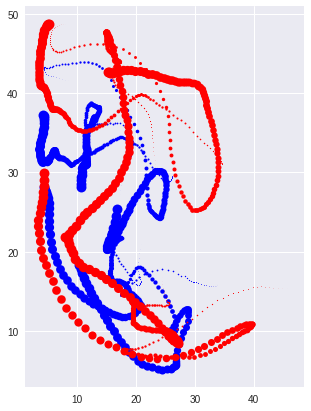

In [8]:
# manual plot check
print(plt_ind)
plot_check(single_game, plt_ind)
plt_ind += 1

#### Build graph and starts training for all single policies

In [10]:
sequence_length = 25
overlap = 10
batch_size = 64
train_all_single_policies(single_game, batch_size, sequence_length, overlap, models_path)

Wroking on policy 0
train len: 36200 test shape: 9050
Horizon 0 ==========
Epoch 0    | loss: 204.19   | time took: 20.96s | validation loss: 193.89  
Epoch 100  | loss: 2.34     | time took: 20.54s | validation loss: 2.60    
Epoch 200  | loss: 2.34     | time took: 20.55s | validation loss: 2.48    
Epoch 300  | loss: 2.02     | time took: 20.54s | validation loss: 2.74    
Epoch 400  | loss: 1.94     | time took: 20.55s | validation loss: 2.52    
Epoch 500  | loss: 1.83     | time took: 20.55s | validation loss: 2.53    
Epoch 600  | loss: 1.83     | time took: 20.61s | validation loss: 2.51    
Epoch 700  | loss: 1.93     | time took: 20.61s | validation loss: 2.57    
Epoch 800  | loss: 1.89     | time took: 20.58s | validation loss: 2.47    
Epoch 900  | loss: 1.91     | time took: 20.54s | validation loss: 2.69    
Epoch 1000 | loss: 1.81     | time took: 20.57s | validation loss: 2.74    
Epoch 1100 | loss: 1.95     | time took: 20.59s | validation loss: 2.73    
Epoch 1200 | 

KeyboardInterrupt: 

### Check performance

In [ ]:
# pad short sequence and chunk long sequence with overlaps
policy = 0
train, target = get_sequences(single_game, policy, sequence_length, overlap)
# create train and test set
p = 0.8 # train percentage
divider = int(len(train)*p)
train_game, test_game = np.copy(train[:divider]), np.copy(train[divider:])
train_target, test_target = np.copy(target[:divider]), np.copy(target[divider:])
Model = ImportGraph('policy0/')

In [ ]:
n = 0

In [ ]:
# manual plot check
plot_check(train_game, n)
n+=1

In [ ]:
# use while loop to make sure the 
train_batches = get_minibatches(train_game, train_target, batch_size, shuffle=False)

check_ind = np.random.randint(0, len(train_game)//batch_size)
print('rand checking index: {0:} out of {1:}'.format(check_ind, len(train_game)//batch_size))

input_xi, output_yi = train_batches

y_pred = Model.forward_pass(input_xi[check_ind], h=1)
y_true = output_yi[check_ind]
    
y_pred = y_pred[0][0].reshape(-1,2)
y_true = y_true[0].reshape(-1,2)

plt.figure(figsize=(15,8))
for k in range(0, len(y_pred)):
    plt.plot(y_pred[:, 0][k], y_pred[:, 1][k], linestyle="None", marker="o", markersize=k, color='g')
    plt.plot(y_true[:, 0][k], y_true[:, 1][k], linestyle="None", marker="o", markersize=k, color='b')

plt.plot(y_pred[:, 0], y_pred[:, 1],'g', y_true[:,0], y_true[:,1], 'b')#, pred_train[:, 0], pred_train[:, 1])
plt.grid(True)

### To do:

    - 1) Regularize the lstm
    - 2) Figure out why there are blanks in the testing
    - 3) may consider to collect those left out from the process of creating batches
    - 4) related to 3), seq_len = 3 may create null batches 

    - Split data to defending and offending, as the model for e.g. forward role in deffending and offending should be pretty different. Remove particular events, like free-throw etc.
    
    - We can use the shot clock as an indicator of when the offending and defending switches.
    
    - The cameras oprate at 25 frames per second, so in order to learn realistic motions, either we sample the 25 frames, or extend the horizon to 50 for example or even longer(this might be too computationally heavy and model would probably drift a lot).
    
    - At the moment if we don't have defending or offending sepearted, at least we need to break down the sequences from the 24 secs shot clock, since it usually stands for a change in game state. (note: shot clock sometimes is None)
    
    - Add tensorboard visualization. Add validation performance (maybe, it would take longer). 
      tensorboard --logdir=./train_logs
      
    - Start thinking about 1) joint training 2) Hidden structure 3) Smooth learning
    - from each sample to next sample theres not much change, subsample them 

### Questions

    * After a team scored and they go back to get ready for defense, is the going back trajectory pretty much random?
    * Do player swap roles during the play? e.g. a forward swapped to a guard, is the forward roles a lot different from gaurds these day? (i.e. can you differentaite a player plaing forward from guard from the game) If yes, then the hidden structure learning/sequencing is necessary. 